# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [4]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "../data/TP4_images/"


In [100]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [103]:
# Hint 
print(base_model)
base_model.fc = nn.Linear(base_model.fc.in_features, 2, bias=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [104]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

In [148]:
from torch.utils.data import Dataset
class OneHotDataset(Dataset):
    def __init__(self, dataset, num_classes=2):
        self.dataset = dataset
        self.num_classes = num_classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        target = torch.nn.functional.one_hot(torch.tensor(target), num_classes=self.num_classes).to(torch.float32)
        return image, target

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [149]:
def precompute_features(
    model: models.ResNet, 
    dataset: torch.utils.data.Dataset, 
    device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    If the model is $f \circ g$ where $f$ is the last layer and $g$ is 
    the rest of the model, it is not necessary to recompute $g(x)$ at 
    each epoch as $g$ is fixed. Hence you can precompute $g(x)$ and 
    create a new dataset 
    $\mathcal{X}_{\text{train}}' = \{(g(x_n),y_n)\}_{n\leq N_{\text{train}}}$

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for the computation
    
    Returns:
    --------
    torch.utils.data.Dataset
        The new dataset with the features precomputed
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    features_list = []
    labels_list = []

    # Remove the last layer (fc) to get the feature extractor part of the model
    precompute_model = nn.Sequential(*list(model.children())[:-1])
    precompute_model.eval()
    precompute_model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            features = precompute_model(X)
            features = features.view(features.size(0), -1)  # Flatten the features
            features_list.append(features.cpu())
            labels_list.append(y.cpu())

    features_tensor = torch.cat(features_list)
    labels_tensor = torch.cat(labels_list)

    new_dataset = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
    return new_dataset

In [150]:
train_dataloader = torch.utils.data.DataLoader(precompute_features(base_model, OneHotDataset(north_dataset), device), batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(precompute_features(base_model, OneHotDataset(test_dataset), device), batch_size=64, shuffle=False)

In [151]:
def train_model(model, lr, criterion, dataloader, epochs=500):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  losses = []
  for _ in range(epochs):
    train_loss = 0
    for X, y in dataloader:
      optimizer.zero_grad()
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss = criterion(y_pred, y)
      loss.backward()
      train_loss += loss.item()
      optimizer.step()
    if _ % 10 == 0:
      print(f'Training loss for {_}/{epochs}: {train_loss}')
    losses.append(train_loss)
  return losses

In [152]:
epochs = 2000
base_model.fc = nn.Linear(512, 2)
linear_classifier = nn.Linear(base_model.fc.in_features, 2, bias=True).to(device)
losses = train_model(linear_classifier, 1e-3, nn.BCEWithLogitsLoss(weight=torch.Tensor([1., 2.])), train_dataloader, epochs)

Training loss for 0/2000: 1.2053449153900146
Training loss for 10/2000: 0.9275075793266296
Training loss for 20/2000: 0.8838087916374207
Training loss for 30/2000: 0.885044276714325
Training loss for 40/2000: 0.8815682530403137
Training loss for 50/2000: 0.8772154450416565
Training loss for 60/2000: 0.8741158246994019
Training loss for 70/2000: 0.8714056611061096
Training loss for 80/2000: 0.8686467409133911
Training loss for 90/2000: 0.8657656311988831
Training loss for 100/2000: 0.8627730011940002
Training loss for 110/2000: 0.8596793413162231
Training loss for 120/2000: 0.856495201587677
Training loss for 130/2000: 0.8532296419143677
Training loss for 140/2000: 0.8498906493186951
Training loss for 150/2000: 0.8464856743812561
Training loss for 160/2000: 0.8430210947990417
Training loss for 170/2000: 0.8395030498504639
Training loss for 180/2000: 0.8359366655349731
Training loss for 190/2000: 0.8323270082473755
Training loss for 200/2000: 0.8286782503128052
Training loss for 210/2000

In [184]:
import numpy as np
def eval_model(model, criterion, test_dataloader):
  model.eval()
  test_error = 0
  all_preds = []
  all_labels = []
  for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    test_error += criterion(y_pred, y).item()
    all_preds.append(y_pred.argmax(dim=1).cpu())
    all_labels.append(y.argmax(dim=1).cpu())
  test_error /= len(test_dataloader)
  print(f'Test error: {test_error}')
  
  all_preds = torch.cat(all_preds).flatten()
  all_labels = torch.cat(all_labels).flatten()
  cm = ConfusionMatrix(task='binary', num_classes=2)
  confusion_matrix = cm(all_preds, all_labels)
  print(f'Confusion Matrix:\n{confusion_matrix}')
  
  acc = Accuracy(task="binary", num_classes=2)
  print(f'Accuracy: {acc(all_preds, all_labels)}')


In [153]:
eval_model(base_model.fc, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.7794966101646423
Confusion Matrix:
tensor([[21,  0],
        [21,  0]])
Accuracy: 0.5


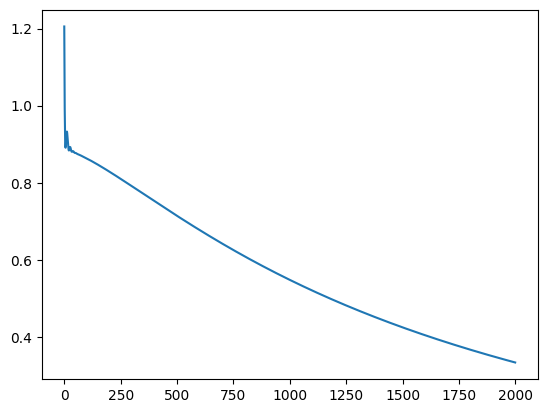

In [154]:
import matplotlib.pyplot as plt
figure = plt.figure()
plt.plot(losses)

In [ ]:
from utils import precompute_features

<div class="alert alert-info">  Example of answer  </div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

In [155]:
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer, self).__init__()
        self.fc1 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        return x

In [156]:
#from utils import LastLayer

resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
#fc.load_state_dict(torch.load("lastlayer.pth", weights_only=True))
resnet.fc = fc
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [176]:
train_dataloader = torch.utils.data.DataLoader(precompute_features(resnet, OneHotDataset(north_dataset), device), batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(precompute_features(resnet, OneHotDataset(test_dataset), device), batch_size=64, shuffle=False)
losses = train_model(resnet.fc, 1e-3, nn.BCEWithLogitsLoss(weight=torch.Tensor([1., 2.])), train_dataloader, 2000)

Training loss for 0/2000: 13.820637702941895
Training loss for 10/2000: 12.37720012664795
Training loss for 20/2000: 10.93376350402832
Training loss for 30/2000: 9.490324020385742
Training loss for 40/2000: 8.046890258789062
Training loss for 50/2000: 6.6037139892578125
Training loss for 60/2000: 5.174555778503418
Training loss for 70/2000: 3.8901143074035645
Training loss for 80/2000: 2.8274216651916504
Training loss for 90/2000: 1.9750540256500244
Training loss for 100/2000: 1.3978400230407715
Training loss for 110/2000: 1.1206529140472412
Training loss for 120/2000: 1.0351314544677734
Training loss for 130/2000: 0.9931834936141968
Training loss for 140/2000: 0.9487006664276123
Training loss for 150/2000: 0.9027615785598755
Training loss for 160/2000: 0.8592334985733032
Training loss for 170/2000: 0.8180869817733765
Training loss for 180/2000: 0.7784451246261597
Training loss for 190/2000: 0.7400522232055664
Training loss for 200/2000: 0.7029698491096497
Training loss for 210/2000: 0

In [177]:
eval_model(resnet.fc.to(device), nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 1.7527709007263184
Confusion Matrix:
tensor([[19,  2],
        [ 7, 14]])
Accuracy: 0.7857142686843872


In [178]:
torch.save(base_model.fc.state_dict(), "lastlayer.pth")

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

In [160]:
class LoRAConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, rank, stride=1, padding=0, bias=False):
        super(LoRAConv, self).__init__()
        
        # First convolution reduces the number of channels (compression)
        self.conv1 = nn.Conv2d(in_channels, rank, kernel_size, stride=stride, padding=padding, bias=bias)
        
        # Second 1x1 convolution restores the number of channels
        self.conv2 = nn.Conv2d(rank, out_channels, kernel_size=1, stride=1, padding=0, bias=bias)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    
class LoRAResNet(nn.Module):
  def __init__(self, base_model, rank=4):
    super(LoRAResNet, self).__init__()
    self.base_model = base_model

    for parameter in self.base_model.parameters():
        parameter.requires_grad = False

    # Replace convolution layers with LoRA convolution layers
    temp = list(self.base_model.named_modules())
    for name, module in temp:
        if isinstance(module, nn.Conv2d) and module.kernel_size != (1, 1):  # Avoid modifying 1x1 convs
            in_channels = module.in_channels
            out_channels = module.out_channels
            kernel_size = module.kernel_size
            stride = module.stride
            padding = module.padding
        
            # Replace with LoRA convolution
            lora_conv = LoRAConv(in_channels, out_channels, kernel_size, rank, stride, padding)
            setattr(self.base_model, name, lora_conv)
    print(self.base_model)          
      
  
  def forward(self, x):
      return self.base_model(x)

In [171]:
from lora_pytorch import LoRA
base_resnet = models.resnet18(weights='DEFAULT')
base_resnet.fc = nn.Linear(base_resnet.fc.in_features, 2, bias=True)
lora_resnet = LoRA.from_module(base_resnet, rank=5)
#lora_resnet = LoRAResNet(base_resnet, rank=4)

In [181]:
train_dataloader = torch.utils.data.DataLoader(OneHotDataset(north_dataset), batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(OneHotDataset(test_dataset), batch_size=64, shuffle=False)

In [173]:
losses = train_model(lora_resnet.to(device), 0.001, nn.BCEWithLogitsLoss(), train_dataloader, 50)

Training loss for 0/50: 0.7859816551208496
Training loss for 10/50: 0.5604530572891235
Training loss for 20/50: 0.3740842044353485
Training loss for 30/50: 0.38268592953681946
Training loss for 40/50: 0.287068635225296


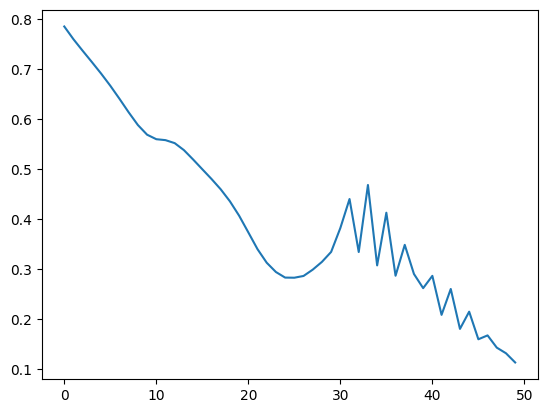

In [174]:
plt.plot(losses)

In [185]:
eval_model(lora_resnet, nn.BCEWithLogitsLoss(), test_dataloader)

Test error: 0.7936198115348816
Confusion Matrix:
tensor([[21,  0],
        [ 9, 12]])
Accuracy: 0.7857142686843872


In [ ]:
torch.save(lora_model.state_dict(), "lora_resnet.pth")

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

In [ ]:
## Data Augmentation
from torchvision.transforms import v2

In [ ]:
lora_model = NotImplementedError  # <YOUR CODE>
assert isinstance(lora_model, models.ResNet)

In [ ]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 